In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
import time

Using TensorFlow backend.


In [2]:
from simulation_tools import Servo, PRBS, simulation_init

In [3]:
class NeuralNetwork:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Dense(4, input_shape=(4,), activation='relu', name="intermediate_layer"))
        self.model.add(Dense(3))
        
        self.stored_weights = None
        self.stored_weight_layer = None
        self.update_intermediate_model()

    
    def predict(self, e, y_prev):
        input_vec = np.array([np.concatenate(([e, y_prev], [self.prev_intermediate_output[0]], 
                                              [self.prev_intermediate_output[3]]))])
        output = self.model.predict(input_vec, batch_size=1)
        
        self.prev_intermediate_output = self.intermediate_layer_model.predict(input_vec, batch_size=1).flatten()

        return output
        
    def copy_weights(self, source_model):
        for i in range(len(self.model.layers)):
            self.model.layers[i].set_weights(source_model.layers[i].get_weights())

            
    def temp_weight_change(self, layer_num, weight_num, index, delta):
        temp_weights = self.model.layers[layer_num].get_weights()
        self.stored_weights = self.model.layers[layer_num].get_weights()
        
        temp_weights[weight_num][index] += delta
        self.model.layers[layer_num].set_weights(temp_weights)

        self.stored_weight_layer = layer_num
    
    def temp_weight_restore(self):
        self.model.layers[self.stored_weight_layer].set_weights(self.stored_weights)

    
    def adjust_weights(self, weight_adjustment_list):
        current_w = 0        
        layers = self.model.layers
        for layer_num, layer in enumerate(layers):
            temp_weights = []
            for weight in layer.get_weights():
                for index in np.ndindex(weight.shape):
                    weight[index] += weight_adjustment_list[current_w]
                    current_w += 1
                temp_weights.append(weight)
                
            self.model.layers[layer_num].set_weights(temp_weights)
        
    def update_intermediate_model(self):
        self.prev_intermediate_output = np.array([0, 0, 0, 0])
        self.intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer("intermediate_layer").output)


In [4]:
# #Checking with C#
# #Output should be -6.16031   ,  4.860726  , -0.67678124
# nn = NeuralNetwork()
# nn.prev_intermediate_output = [3, 0, 0, 4]
# nn.model.layers[0].set_weights((np.array([[-0.46913165, -0.35420346, 0.12766236, 0.52764505], 
#                                 [ 0.7143056, 0.7889276, 0.32565337, 0.44582993], 
#                                 [ 0.44773299, -0.2863869, 0.6054947, 0.15560512], 
#                                 [ -0.17665333, 0.33406478, 0.6498851, 0.39080018]]),
#                                np.array([ 0.006911707, 0.0002995945, 0.0, -0.0034662795])))
# nn.model.layers[1].set_weights((np.array([ [ 0.0005864919, -0.4438249, 0.48540914], 
#                                          [0.25379896, -0.7287866, -0.20937704], 
#                                          [-0.72905433, 0.7343912, -0.81658787],  
#                                          [-0.814179, 0.86968863, 0.9081696]]),
#                                np.array([0.0, -0.00010902006, 0.014027984])))
# nn.predict(1, 2)

In [5]:
class PIDTuner:
    def __init__(self, servo_type, Kp, Ki, Kd):
        self.servo = Servo(servo_type, Kp, Ki, Kd)
        self.nn = NeuralNetwork()
        self.stored_nn = None
    
    def simulate(self, T, y0, r, d, use_nn=True):
        self.servo.PID.reset()
        self.nn.update_intermediate_model()
        self.servo.PID.update_gains(0.32, 0.06, 0.00879)
        dy = np.zeros(len(T))
        y = np.zeros(len(T))
        angle = np.zeros(len(T))
        
        dy[0] = y0[0]
        y[0] = y0[1]
        
        angle[0] = y[0] * 180/math.pi + 180 + d[0]
                
        Kp_list = np.zeros(len(T))
        Ki_list = np.zeros(len(T))
        Kd_list = np.zeros(len(T))

        for i in range(1, len(T)):

            e = r[i] - angle[i-1]
            
            if use_nn:
                e_norm = e/180
                y_prev_norm = (y[i-1]-(-math.pi))/(math.pi-(-math.pi))

                Kp, Ki, Kd = np.absolute(self.nn.predict(e_norm, y_prev_norm).flatten())
                Kp_list[i] = Kp
                Ki_list[i] = Ki
                Kd_list[i] = Kd
                assert not math.isnan(Kp) and not math.isnan(Ki) and not math.isnan(Kd), "NaN Neural Network output"
 
                self.servo.PID.update_gains(Kp, Ki, Kd)
            
            state, angle[i] = self.servo.simulate_step([dy[i-1], y[i-1]], angle[i-1], [T[i-1], T[i]], r[i], d[i])
            dy[i] = state[0]
            y[i] = state[1]
            
            
        return angle, (Kp_list, Ki_list, Kd_list)
    

    def compute_jacobian(self, T, y0, r, d):
        jacobian = np.empty((len(T), self.nn.model.count_params()))
        current_w = 0
        y1, _ = self.simulate(T, y0, r, d)

        layers = self.nn.model.layers
        for layer_num, layer in enumerate(layers):
            for weight_num, weight in enumerate(layer.get_weights()):
                for index in np.ndindex(weight.shape):
                    wij = weight[index]
                    epsilon = max(1, abs(wij)) * math.sqrt(sys.float_info.epsilon)        
                    
                    self.nn.temp_weight_change(layer_num, weight_num, index, epsilon)
        
                    y2, _ = self.simulate(T, y0, r, d)
                    
                    self.nn.temp_weight_restore()
                    
                    for t in range(len(T)):
                        jacobian[t, current_w] = (y1[t] - y2[t])/epsilon
                    current_w += 1
            
        return jacobian, y1
    
    def store_nn(self):
        self.stored_nn = NeuralNetwork()
        self.stored_nn.copy_weights(self.nn.model)
        
    def restore_nn(self):
        self.nn = self.stored_nn

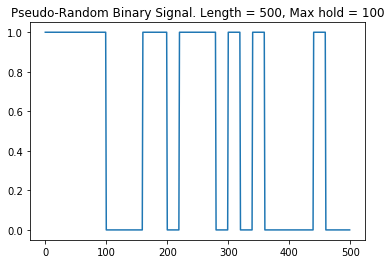

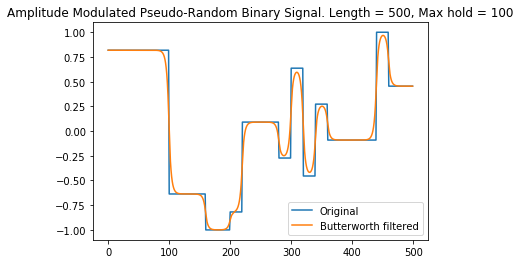

In [6]:
sig_gen = PRBS()

#test
prbs, _ = sig_gen.generate_PRBS(500, 100)#matches the paper
plt.plot(prbs)
plt.title("Pseudo-Random Binary Signal. Length = 500, Max hold = 100")
plt.show()

aprbs = sig_gen.generate_APRBS(500, 100, 2)

aprbs_buttered = sig_gen.apply_butter(aprbs) #Apply butterworth filter

plt.plot(aprbs)
plt.plot(aprbs_buttered)
plt.title("Amplitude Modulated Pseudo-Random Binary Signal. Length = 500, Max hold = 100")
plt.legend(["Original", "Butterworth filtered"])
plt.show()

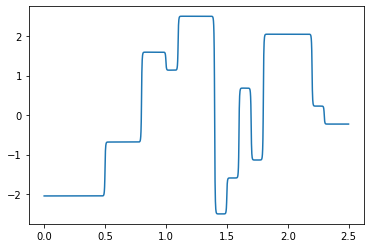

Samples: 500
Starting trial 0
Done iteration: 0 | sq_error: 2.4879984062347464 | adj_sq_error: 4.17255844842964


c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars


Done iteration: 1 | sq_error: 2.4879984062347464 | adj_sq_error: 4.173309347644729
Trial finished, diff: 0.00017996134131359476


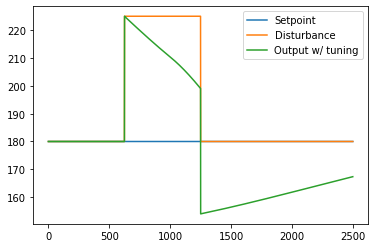

Old best: None | New best: 2.4879984062347464
[array([[ 0.5119272 ,  0.5103702 ,  0.27257055,  0.7249879 ],
       [ 0.19002217,  0.4254226 , -0.19539392,  0.16536993],
       [ 0.1884008 ,  0.82492644,  0.48993415, -0.16249722],
       [-0.318443  , -0.5571183 , -0.04767835,  0.5876289 ]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[array([[ 0.52730393,  0.9084469 , -0.11437088],
       [ 0.3717165 , -0.01090485,  0.00347853],
       [-0.57435644, -0.5008068 ,  0.6504296 ],
       [ 0.5527878 ,  0.30706632,  0.9067991 ]], dtype=float32), array([0., 0., 0.], dtype=float32)]
Samples: 1000
Starting trial 1
Done iteration: 0 | sq_error: 2.009262421809944 | adj_sq_error: 0.7699562056155987
Done iteration: 1 | sq_error: 0.7699562056155987 | adj_sq_error: 0.24110321347454086
Done iteration: 2 | sq_error: 0.24110321347454086 | adj_sq_error: 0.15308276705773352
Done iteration: 3 | sq_error: 0.15308276705773352 | adj_sq_error: 0.15308276705773352
Trial finished, diff: 0.0


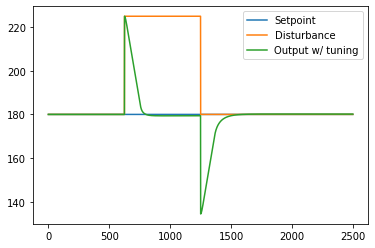

Old best: 2.4879984062347464 | New best: 0.15308276705773352
[array([[-0.6108842 ,  0.4381277 , -0.00993484, -0.20509356],
       [ 0.62604374, -1.0911554 , -0.43919915, -0.26300138],
       [-1.5999312 ,  0.48941523, -0.00663906, -0.63230693],
       [ 0.7926015 , -0.63531697,  0.23468846,  0.11496532]],
      dtype=float32), array([-1.8767351 ,  0.95540476,  0.        ,  0.        ], dtype=float32)]
[array([[-0.29737222,  0.34860826,  0.9210386 ],
       [-2.156398  ,  0.6993196 ,  0.82128257],
       [-0.55159867, -0.6031897 , -0.761427  ],
       [ 0.13563871, -0.00351781, -0.5692942 ]], dtype=float32), array([-0.90064526, -0.7881303 , -0.41691375], dtype=float32)]
Samples: 1500
Starting trial 2
Done iteration: 0 | sq_error: 3.5194475798315956 | adj_sq_error: 1.7448565822390305
Done iteration: 1 | sq_error: 1.7448565822390305 | adj_sq_error: 1.1458204863285775
Done iteration: 2 | sq_error: 1.1458204863285775 | adj_sq_error: 2.93537007376881
Done iteration: 3 | sq_error: 1.145820486

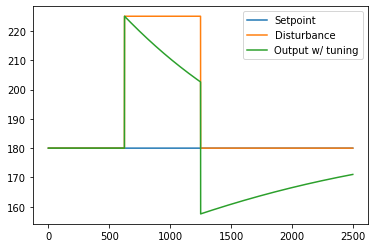

Samples: 2000
Starting trial 3
Done iteration: 0 | sq_error: 1.308401515808449 | adj_sq_error: 0.6520931631074444
Done iteration: 1 | sq_error: 0.6520931631074444 | adj_sq_error: 3.0484343244050875
Done iteration: 2 | sq_error: 0.6520931631074444 | adj_sq_error: 3.128115718995959
Done iteration: 3 | sq_error: 0.6520931631074444 | adj_sq_error: 0.6019793201231763
Done iteration: 4 | sq_error: 0.6019793201231763 | adj_sq_error: 0.5747674666666632
Done iteration: 5 | sq_error: 0.5747674666666632 | adj_sq_error: 0.5747674666666632
Trial finished, diff: 0.0


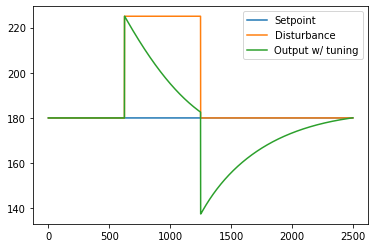

Samples: 2500
Starting trial 4
Done iteration: 0 | sq_error: 0.5956326154371676 | adj_sq_error: 0.3759758448290079
Done iteration: 1 | sq_error: 0.3759758448290079 | adj_sq_error: 0.3189199721338817
Done iteration: 2 | sq_error: 0.3189199721338817 | adj_sq_error: 0.2873776156476934


KeyboardInterrupt: 

In [15]:
T, r, d, d_test, y0 = simulation_init(0.001, 2.5, aprbs_hold=500, aprbs_amp=5)
simulation_length = len(T)
plt.plot(T, d)
plt.show()

sample_increase = 500
max_trials = simulation_length//sample_increase
samples = sample_increase

# samples = simulation_length

best_sq_error = None
trial = 0
rot_tuner = PIDTuner("rotation", 0.32, 0.06, 0.00879)


while(trial < max_trials):
    try:
        rot_tuner.nn = NeuralNetwork()
        prev_adj_sq_error = 0
        iters = 0
        damping_factor = 10
        print("Samples:", samples)
        print("Starting trial", trial)
        trial_finished = False
        while(not trial_finished):

            #Compute jacobian
            J, y = rot_tuner.compute_jacobian(T[:samples], y0, r[:samples], d[:samples]) 

            #Get error of output without weight change
            error = y - r[:samples] 

            try_solve_levenberg = True
            while(try_solve_levenberg):
                #Compute adjustment amount
                A = np.matmul(np.transpose(J), J) + damping_factor * np.identity(J.shape[1])
                B = np.matmul(np.transpose(J), (error))
                adjustment = np.matmul(np.linalg.inv(A), B) 

                #Store a copy of the current neural network before adjusting the weights
                rot_tuner.store_nn()
                rot_tuner.nn.adjust_weights(adjustment)
                #Simulate with the adjusted weights
                y_adj, _ = rot_tuner.simulate(T[:samples], y0, r[:samples], d[:samples]) 

                #Calculate squared error of output without weight change
                sq_error = np.sum(np.square(error))/samples

                #Calculate squared error of output with weight change
                adj_sq_error = np.sum(np.square(y_adj - r[:samples]))/samples

                if adj_sq_error < sq_error:
                    #If squared error with weight change is better, half damping factor and keep new weights
                    damping_factor = damping_factor/2 
                    try_solve_levenberg = False #New sq error is less than the old one
                else:
                    #If not better, double damping factor and restore old weights (from our stored copy)
                    damping_factor = 2 * damping_factor
                    rot_tuner.restore_nn()

            #     print(adjustment)
            
                print("Done iteration:", iters, "| sq_error:", sq_error, "| adj_sq_error:", adj_sq_error)
                
                if (abs(1-adj_sq_error/prev_adj_sq_error) < 0.001):
                    print("Trial finished, diff:", abs(1-adj_sq_error/prev_adj_sq_error))
                    trial_finished = True
                    try_solve_levenberg = False
                    
                prev_adj_sq_error = adj_sq_error
                iters += 1

        y, _ = rot_tuner.simulate(T, y0, r, d_test) 
        plt.plot(r)
        plt.plot(d_test + 180)
        plt.plot(y)
        plt.legend(['Setpoint', 'Disturbance', 'Output w/ tuning'])
        plt.show()
        if (best_sq_error is None or sq_error < best_sq_error) and sq_error != 0:
            print("Old best:", best_sq_error, "| New best:", sq_error)
            best_sq_error = sq_error
            best_model = NeuralNetwork()
            best_model.copy_weights(rot_tuner.nn.model)
            for layer in best_model.model.layers:
                print(layer.get_weights())

        samples += sample_increase
        trial += 1
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("Unable to invert A")
        else:
            raise
    except AssertionError:
        print("NaN neural network output")



In [18]:
#To copy paste into C#
weight_names = ['w1', 'b1', 'w2', 'b2']
w_index = 0
for layer in best_model.model.layers:
    for w in layer.get_weights():
        print("Matrix<double>", weight_names[w_index], "= M.DenseOfArray(new double[,]{", end='')
        for i, row in enumerate(w):
            if type(row) is not np.float32:
                print("{", end='')
                for j in row:
                    print(str(j) + ",", end='')
                print("},", end='')
            else:
                if i == 0:
                    print("{",end='')
                print(str(row) + ",", end='')
                if i == len(w) - 1:
                    print("}",end='')
        print("});")
        w_index += 1

Matrix<double> w1 = M.DenseOfArray(new double[,]{{-0.6108842,0.4381277,-0.009934843,-0.20509356,},{0.62604374,-1.0911554,-0.43919915,-0.26300138,},{-1.5999312,0.48941523,-0.0066390634,-0.63230693,},{0.7926015,-0.63531697,0.23468846,0.11496532,},});
Matrix<double> b1 = M.DenseOfArray(new double[,]{{-1.8767351,0.95540476,0.0,0.0,}});
Matrix<double> w2 = M.DenseOfArray(new double[,]{{-0.29737222,0.34860826,0.9210386,},{-2.156398,0.6993196,0.82128257,},{-0.55159867,-0.6031897,-0.761427,},{0.13563871,-0.0035178065,-0.5692942,},});
Matrix<double> b2 = M.DenseOfArray(new double[,]{{-0.90064526,-0.7881303,-0.41691375,}});


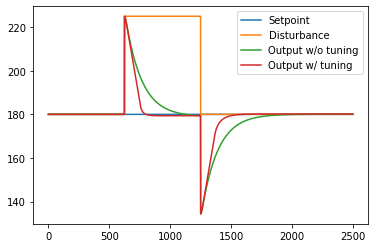

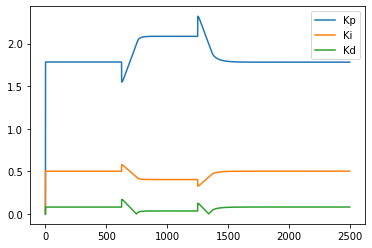

In [17]:
#test

rot_tuner.nn.copy_weights(best_model.model)
y, gains = rot_tuner.simulate(T, y0, r, d_test) 
y_test, _ = rot_tuner.simulate(T, y0, r, d_test, use_nn=False) 
plt.plot(r)
plt.plot(d_test + 180)
plt.plot(y_test)
plt.plot(y)
plt.legend(['Setpoint', 'Disturbance', 'Output w/o tuning', 'Output w/ tuning'])
plt.show()
plt.plot(gains[0])
plt.plot(gains[1])
plt.plot(gains[2])
plt.legend(['Kp', 'Ki', 'Kd'])
plt.show()